In [11]:
'''
Past stock data provided by professor with an api
'''
def get_data (start_date, end_date):
    
    stock_list = stocklist()
    success_count = int(0)
    fail_count = int(0)
    for stockname in stock_list:
        '''
        First start with the full stock list
        Get all of the stocks from professor's database
        If the stock is not available, remove that stock from our database
        '''
        stock = stockname[0]

        try:
            link = 'http://140.116.86.241:15000/api/v1/bargain_data'
            url = link + '/' + stock + '/' + start_date + '/' + end_date
            with urllib.request.urlopen(url) as response:
               data = response.read().decode()
            success_count = success_count + 1
        except:
            print('failed of retrieving', stock)
            # remove_unavailable_stock(stock)
            fail_count = fail_count + 1
            continue       


        # load data with JSON package
        try:
               js = json.loads(data)
        except:
               js = None     

        # Get specific item
        '''
        For the current stock, insert each record into the database 
        The date is formated in yyyy-mm-dd
        '''

        for timestamp in js:
            try:
                date = timestamp['date']
                date = datetime.datetime.fromtimestamp(date) #read the date using datetimepackage
                date = date.strftime('%Y-%m-%d') #format the date
                db.execute( "INSERT INTO stock (stock_code_id, open, date,transaction_volume, low, turnover, close, capacity, high, changing) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)",
                        (timestamp['stock_code_id'], timestamp['open'], date,timestamp['transaction_volume'], 
                        timestamp['low'],timestamp['turnover'], timestamp['close'], timestamp['capacity'], 
                        timestamp['high'], timestamp['change']))
                mydb.commit()
            except:
                # print(timestamp['stock_code_id'],date)
                continue   
    print('success:' , success_count)
    print('fail:' , fail_count)

In [16]:
import timeit
import csv
class twstock:
    def __init__(self, stocknum, purpose):   
        '''
        stocknum: the returned tuple from sql, e.g. (2476,)
        '''
        self.stocknum = stocknum[0]
        self.stocktuple = stocknum        
        self.purpose = purpose
        self.last_date = self.sql_data_last()
        
    def create_query(self, var1):
        # create sql query
        if var1 == 'sell':
            return "SELECT date, high FROM stock WHERE stock_code_id = %s ORDER BY date"
        elif var1 == 'open':
            return "SELECT date, open FROM stock WHERE stock_code_id = %s ORDER BY date"
        else:
            return "SELECT date, close FROM stock WHERE stock_code_id = %s ORDER BY date"
    
    def sql_data_last(self):
        # return the last date in the data
        
        # get the sql query that will return all date and price of the stock
        SQL_query = self.create_query(self.purpose)
        stockq = self.stocktuple
        db.execute(SQL_query, stockq)
        result = db.fetchall()
        last_date = result[-1][0]
        return last_date
    
    def return_dataframe(self, target):
        # return data of selected stock from sql database
        SQL_query = self.create_query(self.purpose)
        stockq = self.stocktuple
        db.execute(SQL_query, stockq)
        result = db.fetchall()
        df = pd.DataFrame(result, columns=["date", target])
        return df    
    
    def predict(self, target):
        df = self.return_dataframe(target)
        try:
            self.do_prediction(df, target)
            print("finished predicting", self.stocknum)
        except:
            print("problem with", self.stocknum)
            
    
    
    def do_prediction(self, df, target):
        # record start time
        start = timeit.default_timer()
        
        #set predict date        
        predict_date = 5
        
        # set epoch of model
        epo = 100
        
        #setting figure size
        rcParams['figure.figsize'] = 20,10

        #for normalizing data
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0, 1))

        #setting index as date
        df['date'] = pd.to_datetime(df.date,format='%Y-%m-%d')
        df.index = df['date']

        #creating dataframe
        data = df.sort_index(ascending=True, axis=0)
        new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', target])
        for i in range(0,len(data)):
            new_data['Date'][i] = data['date'][i]
            new_data[target][i] = data[target][i]

        #setting index
        new_data.index = new_data.Date
        new_data.drop('Date', axis=1, inplace=True)

        #creating train and test sets
        dataset = new_data.values
        train = dataset[0:2*len(dataset)//3,:]
        valid = dataset[2*len(dataset)//3:,:]

        #converting dataset into x_train and y_train
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(dataset)

        x_train, y_train = [], []
        for i in range(60,len(train)):
            x_train.append(scaled_data[i-60:i-(predict_date-1),0])
            y_train.append(scaled_data[i,0])

        x_train, y_train = np.array(x_train), np.array(y_train)

        x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

        #create and fit the LSTM network
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
        
        '''
        # additional layers
        model.add(Dropout(0.2))
        # Adding a second LSTM layer and some Dropout regularisation
        model.add(LSTM(units = 50, return_sequences = True))
        model.add(Dropout(0.2))
        # Adding a third LSTM layer and some Dropout regularisation
        model.add(LSTM(units = 50, return_sequences = True))
        model.add(Dropout(0.2))
        '''
        # Adding a 4 LSTM layer 
        model.add(LSTM(units=50))
        
        # Additional Dropout regularisation
        # model.add(Dropout(0.2))
        model.add(Dense(1))

        model.compile(loss='mean_squared_error', optimizer='adam')
        model.summary()
        
        # training
        model.fit(x_train, y_train, epochs=epo, batch_size=16, verbose=2)
        inputs = new_data[len(new_data) - len(valid) - 60:].values
        inputs = inputs.reshape(-1,1)
        inputs  = scaler.transform(inputs)

        # testing
        X_test = []
        for i in range(60,inputs.shape[0]+predict_date):
            X_test.append(inputs[i-60:i-(predict_date-1),0])
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
        
        predict_price = model.predict(X_test)
        predict_price = scaler.inverse_transform(predict_price)

        '''
        #for plotting
        train = new_data[:2*len(dataset)//3]
        valid = new_data[2*len(dataset)//3:]
        valid['Predictions'] = predict_price[:len(predict_price)-5]
        # print(valid['Predictions'])
        # print(valid['Close'])
        plt.figure(figsize=(16,8))
        plt.plot(train[target], label='training')
        plt.plot(valid[[target]], label='validation')
        plt.plot(valid[['Predictions']], label='prediction')
        plt.legend()
        plt.show()
        '''
        
        
        if self.purpose == 'buy' or 'sell' :
            # Save the result into database
            max_value = float(max(predict_price[len(predict_price)-predict_date:len(predict_price)+1])[0])
            min_value = float(min(predict_price[len(predict_price)-predict_date:len(predict_price)+1])[0])
            max_index = int(np.argmax(predict_price[len(predict_price)-predict_date:len(predict_price)+1], axis=0)[0])
            min_index = int(np.argmin(predict_price[len(predict_price)-predict_date:len(predict_price)+1], axis=0)[0])
            max_date = turn_date(self.last_date, max_index)
            min_date = turn_date(self.last_date, min_index)
            predict_date = datetime.date.today()
            change = (max_value - min_value) / min_value * 100
            if max_index > min_index:
                insert_prediction(self.stocknum, predict_date,min_value, min_date, max_value, max_date, change, self.purpose)
            if max_index < min_index: # and self.purpose == 'sell':
                insert_prediction(self.stocknum, predict_date,min_value, min_date, max_value, max_date, -change, self.purpose)
        
        if self.purpose == 'graph' or 'sell':
            #for plotting
            train = new_data[:2*len(dataset)//3]
            valid = new_data[2*len(dataset)//3:]
            valid['Predictions'] = predict_price[:len(predict_price)-5]
            predict = new_data[-30:]
            predict['Predictions'] = predict_price[len(predict_price)-35:len(predict_price)-5]
            for i in range(0,5):
                row = pd.Series({"Predictions":predict_price[-5+i][0]},name=turn_date(self.last_date,i))
                predict = predict.append(row)

            plt.figure(figsize=(16,16))
            fig, axs = plt.subplots(2, 1, constrained_layout=True)
            axs[0].plot(valid[[target]], label='validation')
            axs[0].plot(valid[['Predictions']], 'r:', label='prediction', )
            axs[0].plot(train[target], label='training')
            axs[0].set_title('Model result')
            axs[0].set_xlabel('date')
            axs[0].set_ylabel(target)
            axs[0].legend()

            fig.suptitle(self.stocknum, fontsize=16)
            axs[1].plot(predict[[target]], label='validation')
            axs[1].plot(predict[['Predictions']], 'r:', label='prediction', )
            axs[1].set_title('Prediction for next 5 dates')
            axs[1].set_xlabel('Date')
            axs[1].set_ylabel(target)
            axs[1].legend()
            file_name = str(self.stocknum)+'.jpg'
            plt.savefig(file_name)
            plt.show()            
            print(predict[-5:])

        '''
        # for validation, writing rms into csv file for presentation
        rms=np.sqrt(np.mean(np.power((valid-predict_price[:len(predict_price)-5]),2)))
        print("rms:",rms)
        stop = timeit.default_timer()  
        processing_time = stop - start
        print('Time: ', stop - start)
        with open('ep10', 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([self.stocknum, rms[[target]], processing_time])
        '''

Model: "sequential_411"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_822 (LSTM)              (None, 56, 50)            10400     
_________________________________________________________________
lstm_823 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dense_411 (Dense)            (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
89/89 - 3s - loss: 0.0190
Epoch 2/100
89/89 - 4s - loss: 0.0037
Epoch 3/100
89/89 - 4s - loss: 0.0035
Epoch 4/100
89/89 - 2s - loss: 0.0033
Epoch 5/100
89/89 - 2s - loss: 0.0033
Epoch 6/100
89/89 - 2s - loss: 0.0030
Epoch 7/100
89/89 - 3s - loss: 0.0029
Epoch 8/100
89/89 - 2s - loss: 0.0028
Epoch 9/100
89/89 - 3s - loss: 0.0028
Epoch 10/100
89/89 - 2s - loss: 0.00

<ipython-input-16-3a269e6547f5>:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predict_price[:len(predict_price)-5]
<ipython-input-16-3a269e6547f5>:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict['Predictions'] = predict_price[len(predict_price)-35:len(predict_price)-5]


<Figure size 1152x1152 with 0 Axes>

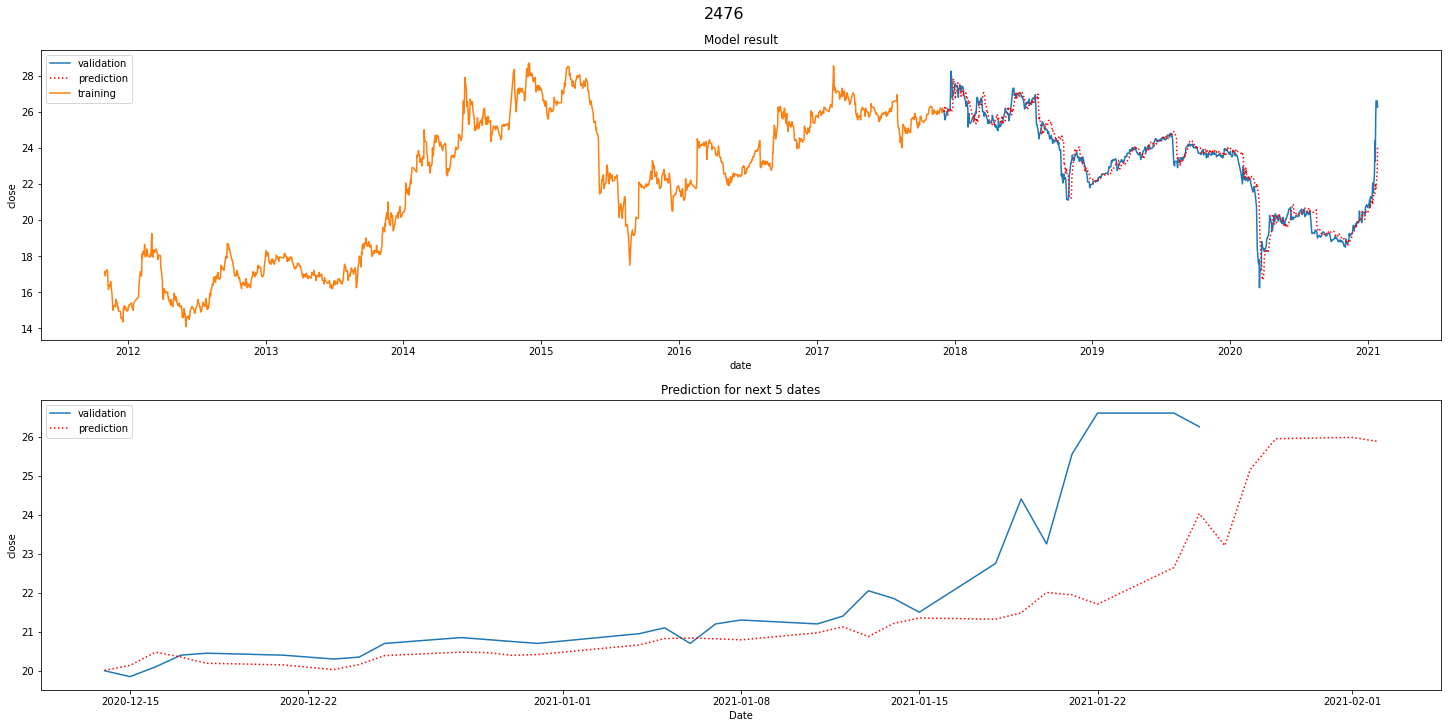

           close  Predictions
Date                         
2021-01-27   NaN    23.205132
2021-01-28   NaN    25.156713
2021-01-29   NaN    25.942608
2021-02-01   NaN    25.977659
2021-02-02   NaN    25.874792
finished predicting 2476
Model: "sequential_412"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_824 (LSTM)              (None, 56, 50)            10400     
_________________________________________________________________
lstm_825 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dense_412 (Dense)            (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
89/89 - 2s - loss: 0.0019
Epoch 2/100
89/89 - 3s - loss: 9.0854e-04
Epoch 3/100
89/89 - 3s - loss: 8.3598e-04
Epoch 4/100
89/89 - 3

<ipython-input-16-3a269e6547f5>:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predict_price[:len(predict_price)-5]
<ipython-input-16-3a269e6547f5>:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict['Predictions'] = predict_price[len(predict_price)-35:len(predict_price)-5]


<Figure size 1152x1152 with 0 Axes>

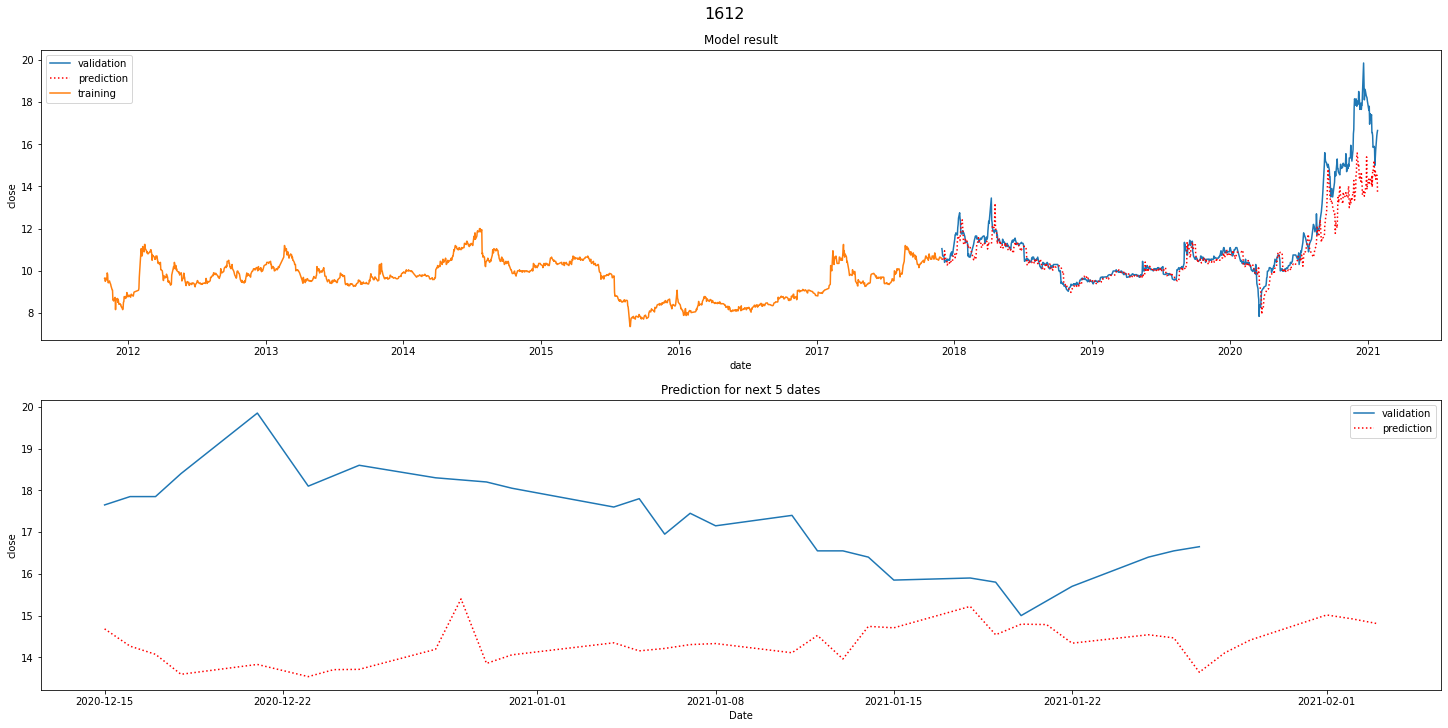

           close  Predictions
Date                         
2021-01-28   NaN    14.108161
2021-01-29   NaN    14.414308
2021-02-01   NaN    15.014691
2021-02-02   NaN    14.921789
2021-02-03   NaN    14.806641
finished predicting 1612


"\ninsert_trade_records()\nupdate_data()\n# prediction for sell\nstock_list = purchased_stocks()\nfor stock in stock_list:\n    current_stock = twstock(stock, 'sell')\n    current_stock.predict('high')  \n\n"

In [17]:
import urllib.request
import pymysql
import datetime
import pandas as pd
import numpy as np
import tensorflow 
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from datetime import timedelta
import time
import random
import json
import sys

# start database connection
mydb = pymysql.connect(host='127.0.0.1', user='root', password='Sc5413628', database='stock_database')
db = mydb.cursor()

def turn_date(last_data_date, target):
    # turn index into date
    target = target + 1
    if last_data_date.weekday() + target > 4:
        target = target + 2
    return last_data_date + timedelta(days=target)

def stocklist():
    # get stock id from database
    db.execute("SELECT stock_code_id FROM twse")
    result = db.fetchall()
    return result

def stocklist_under40():
    # get stock id from database that price are less than 40
    db.execute("SELECT stock_code_id FROM stock_database.stock where date = '20201231' and low < 40;")
    result = db.fetchall()
    return result

def remove_unavailable_stock(stock_id):
    # remove stock that is not anvailable from database
    SQL_query = """DELETE FROM twse WHERE stock_code_id = %s"""
    db.execute(SQL_query, (stock_id,))
    mydb.commit
    
def insert_prediction(stock_id, predict_date,min_value, min_date, max_value, max_date, change, purpose):   
    # insert prediction data into database
    db.execute( "INSERT INTO prediction (stock_code_id, predict_date, predicted_lowest_price, lowest_date, predicted_highest_price, highest_date, expected_change, purpose) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)",
            (stock_id, predict_date,min_value, min_date, max_value, max_date, change, purpose))
    mydb.commit()

def insert_trade_records():
    trade_record = pd.read_csv('trade_records_1229.csv')
    count = 0
    for index, row in trade_record.iterrows():
        try:
            dt = datetime.datetime.strptime(row.交易時間, '%d/%m/%Y %H:%M')
            dt = dt.date()
            converter = lambda x : 'buy' if (x == '買進') else 'sell'
            db.execute("INSERT INTO transaction_result (stock_code_id,transaction_date,action, transaction_price, transaction_amount) values(%s, %s, %s, %s, %s)",
                           (int(row.股票代碼), dt, converter(row.交易類型), float(row.交易價格), int(row.交易數量)))
            mydb.commit()
            count = count + 1            
        except:
            continue
    print("successfully import {} records".format(count))
    
def best_stocks(date):
    # select first 30 stock from database after buy prediction
    query = "select stock_code_id FROM stock_database.prediction where predict_date = date'" + date + "' and purpose = 'buy' order by expected_change desc limit 30;"
    db.execute(query)
    result = db.fetchall()
    return result

def purchased_stocks():
    # select remaining stock on hand
    db.execute("SELECT distinct stock_code_id FROM stock_database.transaction_result where action = 'buy' and stock_code_id not in (select stock_code_id FROM stock_database.transaction_result where action = 'sell');")
    result = db.fetchall()
    return result

def transform_date(date):   #民國轉西元
        y, m, d = date.split('/')
        return str(int(y)+1911) + '/' + m  + '/' + d
    
def getDayKBar(sid, date):
    # use API to update data of last two day
    try:
        html=urllib.request.urlopen('http://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date='+date+'&stockNo='+sid)
        content = html.read().decode('utf-8')
        jcontent=json.loads(content)
        df = jcontent['data']
    except:
        print("problem with link :", sid)
        df = None
    # i = 0
    if df != None:
        for data in df[:]:
            try:
                tmpday = datetime.datetime.strptime(transform_date(data[0]), '%Y/%m/%d')
                db.execute("INSERT INTO stock (stock_code_id, open, date,transaction_volume, low, turnover, close, capacity, high, changing) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)",
                            (sid, float(data[3].replace(',','')), tmpday.strftime('%Y-%m-%d'),float(data[8].replace(',','')), 
                            float(data[5].replace(',','')),float(data[2].replace(',','')), float(data[6].replace(',','')), float(data[1].replace(',','')), 
                            float(data[4].replace(',','')), float(data[7].replace('+',''))))
                mydb.commit()
                # i = i+1
                print("success:", sid, tmpday)            
            except:
                print("problem with insert:", sid)
    
        
def update_data():          
    # function to update data, need to wait for 5-9 second after each stock
    stock_list = stocklist()
    print("start")
    for stock in stock_list[:]:
        getDayKBar(str(stock[0]), '202001')
        print("wait")
        time.sleep(random.randint(5, 8))
'''
# run rms test for first 10 stocks
stock_list = stocklist()
with open('ep10.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['stock_no', 'rms', 'runtime'])
for stock in stock_list[:10]:
    current_stock = twstock(stock, 'buy')
    current_stock.predict('close')
'''

# update_data()

# get_data('20201216','20201227')

# run the model for all stock
stock_list = stocklist_under40()
# stock_list = [(2476,), (1612,)]
for stock in stock_list:
    current_stock = twstock(stock, 'buy')
    current_stock.predict('close')


'''
# run and save graph for best 30 stocks
stock_list = best_stocks('20210126')
for stock in stock_list:
    current_stock = twstock(stock, 'graph')
    current_stock.predict('close')
'''
'''
insert_trade_records()
update_data()
# prediction for sell
stock_list = purchased_stocks()
for stock in stock_list:
    current_stock = twstock(stock, 'sell')
    current_stock.predict('high')  

'''

In [18]:
mydb.close()